<a href="https://colab.research.google.com/github/signLangProjectNIC/tf-cnn-lstm4/blob/main/tf_cnn_lstm17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#here we are going to experiment with LSTM regularisation
'''
for 0.3 l2 of CNN3D
I still suspect a little overfitting
So here we are going to solve that using lstm regularization
'''

'\nfor 0.3 l2 of CNN3D\nI still suspect a little overfitting\nSo here we are going to solve that using lstm regularization\n'

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.68.144.130:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.68.144.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.68.144.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [5]:
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from moviepy.editor import *
import cv2
import moviepy
import sys
import tensorflow.keras.layers as tfKL
from tensorflow.keras import regularizers
from keras.layers import Activation, Dense 
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import random
import pandas as pd
nLookback=4
nSubsequences= 5
height=50
width=50
channels=3
nCategories=8
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
X=np.load("/content/gdrive/MyDrive/hand sign database array X.npy")
Y=np.load("/content/gdrive/MyDrive/hand sign database array Y.npy")
Xmean=np.mean(X)
Xstd=np.std(X)
print(Xmean)
print(Xstd)
X=(X-Xmean)/Xstd
nCategories=8
Xmean=np.mean(X)
Xstd=np.std(X)
print(Xmean)
print(Xstd)
trainSetX=list()
testSetX=list()
trainSetY=list()
testSetY=list()
valSetX=list()
valSetY=list()
for i in range(nCategories):
  wholeset=list()
  for j in range(np.shape(Y)[0]):
    if(Y[j]==i):
      wholeset.append(j)
  # idk=X[wholeset]
  print(np.shape(wholeset))
  traini,testnvali=train_test_split(wholeset,test_size=0.25)
  vali,testi=train_test_split(testnvali,test_size=(10/35))
  for x in traini:
    trainSetX.append(X[x])
    trainSetY.append(Y[x])
  for x in testi:
    testSetX.append(X[x])
    testSetY.append(Y[x])
  for x in vali:
    valSetX.append(X[x])
    valSetY.append(Y[x])
print(np.shape(trainSetX))
print(np.shape(valSetX))
print(np.shape(testSetX))

76.08792970149254
37.221323957827764
-7.58063079786192e-17
0.9999999999999996
(52,)
(52,)
(52,)
(52,)
(52,)
(40,)
(52,)
(50,)
(301, 20, 50, 50, 3)
(70, 20, 50, 50, 3)
(31, 20, 50, 50, 3)


In [7]:
def createModel(layers,metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam'):
  with tpu_strategy.scope():
    model=tf.keras.Sequential()
    for layer in layers:
      model.add(layer)
    model.compile(metrics=metrics,loss=loss,optimizer=optimizer)    
    return model

In [25]:
def evaluateModel(layers,trainX=trainSetX,trainY=trainSetY,valX=valSetX,valY=valSetY,metrics=['accuracy'],loss='categorical_crossentropy',optimizer='adam',nSubsequences=5,nLookback=4,nCategories=8,verbose=2,epochs=500,batch_size=10):
  
  with tpu_strategy.scope(): 
    trainX=np.asarray(trainX)
    trainY=np.asarray(trainY)
    valX=np.asarray(valX)
    valY=np.asarray(valY)
    height=trainX.shape[2]
    width=trainX.shape[3]
    channels=trainX.shape[4]
    trainX=trainX.reshape((trainX.shape[0],nSubsequences,nLookback,trainX.shape[2],trainX.shape[3],trainX.shape[4]))
    trainY=tf.keras.utils.to_categorical(trainY)

    
    valX=valX.reshape((valX.shape[0],nSubsequences,nLookback,valX.shape[2],valX.shape[3],valX.shape[4]))
    valY=tf.keras.utils.to_categorical(valY)
  print(np.shape(trainX))
  print(np.shape(trainY))
  print(np.shape(valX))
  print(np.shape(valY))
  with tpu_strategy.scope():
    model=createModel(layers=layers,metrics=metrics,loss=loss,optimizer=optimizer)
    # print(trainX)
    history=model.fit(x=trainX,y=trainY,batch_size=batch_size,epochs=epochs,verbose=verbose,validation_data =(valX,valY))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  return model

In [29]:
def testAccuracy(Result=Result,testSetY=testSetY):
  diff=np.asarray(Result)-np.asarray(testSetY)
  answer=(((np.shape(diff))[0]-np.count_nonzero(diff)))/(np.shape(diff)[0])
  return answer

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 17s - loss: 9.0113 - accuracy: 0.3090 - val_loss: 5.4523 - val_accuracy: 0.3571
Epoch 2/500
31/31 - 3s - loss: 3.9507 - accuracy: 0.5316 - val_loss: 3.0376 - val_accuracy: 0.4857
Epoch 3/500
31/31 - 3s - loss: 2.5607 - accuracy: 0.6213 - val_loss: 2.3765 - val_accuracy: 0.6286
Epoch 4/500
31/31 - 3s - loss: 2.2535 - accuracy: 0.6944 - val_loss: 2.3056 - val_accuracy: 0.6714
Epoch 5/500
31/31 - 3s - loss: 2.1346 - accuracy: 0.7243 - val_loss: 1.8720 - val_accuracy: 0.7571
Epoch 6/500
31/31 - 3s - loss: 1.6313 - accuracy: 0.7608 - val_loss: 1.7623 - val_accuracy: 0.7571
Epoch 7/500
31/31 - 3s - loss: 1.4069 - accuracy: 0.7608 - val_loss: 1.5403 - val_accuracy: 0.7143
Epoch 8/500
31/31 - 3s - loss: 1.3760 - accuracy: 0.7907 - val_loss: 1.5208 - val_accuracy: 0.7571
Epoch 9/500
31/31 - 3s - loss: 1.3053 - accuracy: 0.8140 - val_loss: 1.5559 - val_accuracy: 0.7429
Epoch 10/500
31/31 - 3s - loss: 1.2852 - accur

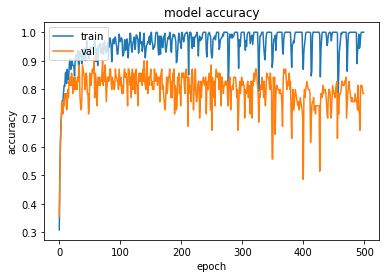

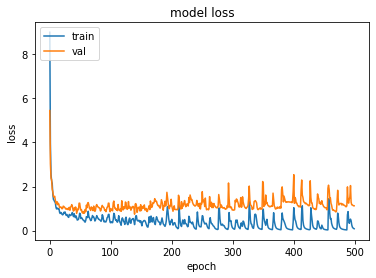

 Our result:- 
 [0 5 0 0 6 7 3 1 2 2 2 2 3 3 3 3 4 4 4 4 4 5 5 6 6 6 6 7 3 7 1]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]


TypeError: ignored

In [27]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.3)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy())

In [28]:
print(Result)

[0 5 0 0 6 7 3 1 2 2 2 2 3 3 3 3 4 4 4 4 4 5 5 6 6 6 6 7 3 7 1]


In [30]:
print(" Our result:- \n",Result)
print("Real testY:- \n",testSetY)
print("Accuracy:- \n",testAccuracy())

 Our result:- 
 [0 5 0 0 6 7 3 1 2 2 2 2 3 3 3 3 4 4 4 4 4 5 5 6 6 6 6 7 3 7 1]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.7741935483870968


(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 18s - loss: 8.0454 - accuracy: 0.3455 - val_loss: 4.8383 - val_accuracy: 0.4714
Epoch 2/500
31/31 - 3s - loss: 3.9031 - accuracy: 0.4983 - val_loss: 3.4765 - val_accuracy: 0.4429
Epoch 3/500
31/31 - 3s - loss: 2.9608 - accuracy: 0.5914 - val_loss: 2.5616 - val_accuracy: 0.6571
Epoch 4/500
31/31 - 3s - loss: 2.4289 - accuracy: 0.6246 - val_loss: 2.2539 - val_accuracy: 0.6286
Epoch 5/500
31/31 - 3s - loss: 1.8954 - accuracy: 0.6910 - val_loss: 1.8374 - val_accuracy: 0.8000
Epoch 6/500
31/31 - 3s - loss: 1.7229 - accuracy: 0.7542 - val_loss: 1.8857 - val_accuracy: 0.6857
Epoch 7/500
31/31 - 3s - loss: 1.9367 - accuracy: 0.7143 - val_loss: 1.8761 - val_accuracy: 0.6857
Epoch 8/500
31/31 - 3s - loss: 1.8497 - accuracy: 0.7342 - val_loss: 2.4163 - val_accuracy: 0.7286
Epoch 9/500
31/31 - 3s - loss: 1.9382 - accuracy: 0.7641 - val_loss: 1.6765 - val_accuracy: 0.7571
Epoch 10/500
31/31 - 3s - loss: 1.1747 - accur

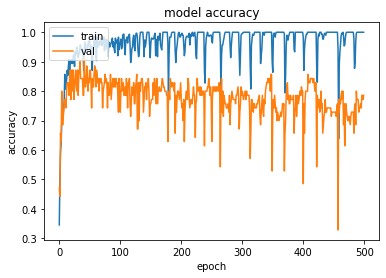

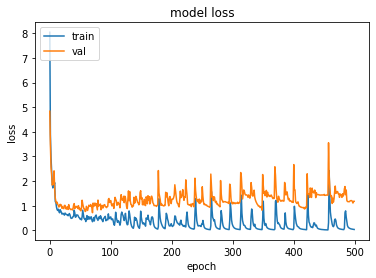

 Our result:- 
 [0 0 0 0 1 7 3 1 2 2 2 2 3 3 5 3 4 4 4 4 4 0 5 5 6 6 6 7 3 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.7741935483870968


In [31]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.2)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy())

In [34]:
print(Result)
print(testSetY)
print(testAccuracy(Result,testSetY))

[0 0 0 0 1 7 3 1 2 2 2 2 3 3 5 3 4 4 4 4 4 0 5 5 6 6 6 7 3 7 7]
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
0.7741935483870968


(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 17s - loss: 7.8599 - accuracy: 0.2326 - val_loss: 4.6534 - val_accuracy: 0.4714
Epoch 2/500
31/31 - 3s - loss: 3.7920 - accuracy: 0.4352 - val_loss: 3.1620 - val_accuracy: 0.5714
Epoch 3/500
31/31 - 3s - loss: 3.0724 - accuracy: 0.5615 - val_loss: 3.3933 - val_accuracy: 0.4143
Epoch 4/500
31/31 - 3s - loss: 3.1902 - accuracy: 0.5017 - val_loss: 3.0246 - val_accuracy: 0.6286
Epoch 5/500
31/31 - 3s - loss: 2.9675 - accuracy: 0.5183 - val_loss: 3.0701 - val_accuracy: 0.4714
Epoch 6/500
31/31 - 3s - loss: 2.7828 - accuracy: 0.5216 - val_loss: 2.6752 - val_accuracy: 0.6143
Epoch 7/500
31/31 - 3s - loss: 2.4362 - accuracy: 0.5648 - val_loss: 2.4746 - val_accuracy: 0.5714
Epoch 8/500
31/31 - 3s - loss: 2.4272 - accuracy: 0.5947 - val_loss: 2.4695 - val_accuracy: 0.6571
Epoch 9/500
31/31 - 3s - loss: 2.2731 - accuracy: 0.6777 - val_loss: 2.4466 - val_accuracy: 0.6000
Epoch 10/500
31/31 - 3s - loss: 2.2689 - accur

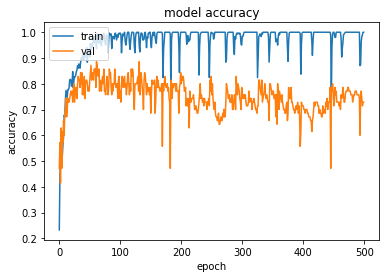

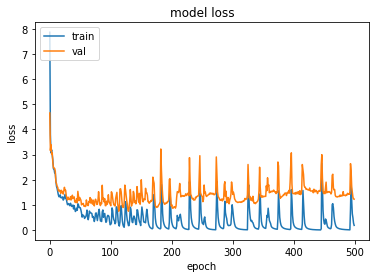

 Our result:- 
 [0 0 5 0 1 7 1 1 2 2 2 2 3 3 0 3 4 4 4 4 4 5 5 1 4 6 6 7 7 7 7]
Real testY:- 
 [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7]
Accuracy:- 
 0.8064516129032258


In [35]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.4)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=100,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

(301, 5, 4, 50, 50, 3)
(301, 8)
(70, 5, 4, 50, 50, 3)
(70, 8)
Epoch 1/500
31/31 - 17s - loss: 8.9696 - accuracy: 0.2292 - val_loss: 4.9583 - val_accuracy: 0.4143
Epoch 2/500
31/31 - 3s - loss: 3.7169 - accuracy: 0.4817 - val_loss: 2.8049 - val_accuracy: 0.4857
Epoch 3/500
31/31 - 3s - loss: 2.2707 - accuracy: 0.6279 - val_loss: 2.2093 - val_accuracy: 0.7000
Epoch 4/500
31/31 - 3s - loss: 1.9094 - accuracy: 0.7076 - val_loss: 1.8961 - val_accuracy: 0.6571
Epoch 5/500
31/31 - 3s - loss: 1.8018 - accuracy: 0.7409 - val_loss: 1.8349 - val_accuracy: 0.7000
Epoch 6/500
31/31 - 3s - loss: 1.5191 - accuracy: 0.7475 - val_loss: 1.4866 - val_accuracy: 0.7714
Epoch 7/500
31/31 - 3s - loss: 1.4659 - accuracy: 0.7841 - val_loss: 1.5582 - val_accuracy: 0.8143
Epoch 8/500
31/31 - 4s - loss: 1.2924 - accuracy: 0.7973 - val_loss: 1.3149 - val_accuracy: 0.7714
Epoch 9/500
31/31 - 3s - loss: 1.0654 - accuracy: 0.8140 - val_loss: 1.1903 - val_accuracy: 0.8000
Epoch 10/500
31/31 - 3s - loss: 0.9800 - accur

In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.4)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=160,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))

In [ ]:
layers=list()
layers.append(tfKL.TimeDistributed(tfKL.Conv3D(filters=64,kernel_size=(3,3,3),activation='relu',trainable=True,kernel_regularizer=regularizers.l2(l2=0.4)),input_shape=(None,nLookback,height,width,channels)))
layers.append(tfKL.TimeDistributed(tfKL.Flatten()))
layers.append(tfKL.LSTM(units=70,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.LSTM(units=70,activation='tanh',trainable=True,kernel_regularizer=regularizers.l2(l2=0.01)))
layers.append(tfKL.Dense(units=8,activation='softmax',trainable=True))


with tpu_strategy.scope(): 
  Result=evaluateModel(layers).predict(np.reshape(np.asarray(testSetX),newshape=(31,nSubsequences,nLookback,50,50,3)))
  Result=np.argmax(Result,axis=1)
  print(" Our result:- \n",Result)
  print("Real testY:- \n",testSetY)
  print("Accuracy:- \n",testAccuracy(Result,testSetY))